# The World Settlement Footprint (WSF)

* **Products used:** 
[wsf_2015](https://explorer.digitalearth.africa/products/wsf_2015), [wsf_2019](https://explorer.digitalearth.africa/products/wsf_2019), [wsf_evolution](https://explorer.digitalearth.africa/products/wsf_evolution)

## Background






## Description

In this notebook we will load WSF data using `dc.load()` to return a map of settlement footprint  for a specified area.

Topics covered include:
1. Inspecting the WSF product in the datacube
2. Using the `dc.load()` function to load in LULC data
3. Plotting LULC using the `plot_lulc()` function
4. An example analysis of the area of LULC classes in a given area
5. Loading and plotting the 'cover fractions' in CGLS

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from deafrica_tools.plotting import display_map, plot_lulc

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="wsf")

### List measurements

We can inspect the data available for WSF using datacube's `list_measurements` functionality. The table below lists the products and measurements available for the three WSF datasets indexed within DE Africa's datacube. 

In [3]:
product_name = ['wsf_2015', 'wsf_2019', 'wsf_evolution'] 

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

,,name,dtype,units,nodata,aliases
product,measurement,,,,,
wsf_2015,wsf2015,wsf2015,uint8,1,0.0,[wsf2015]
wsf_2019,wsf2019,wsf2019,uint8,1,0.0,[wsf2019]
wsf_evolution,wsfevolution,wsfevolution,int32,1,0.0,[wsfevolution]


### Analysis parameters

This section defines the analysis parameters, including:

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `resolution`: the pixel resolution to use for loading the LULC dataset. The native resolution of the product is 10 metres i.e. `(-10,10)`
* `measurements`: the 'band' or measurement to load from the product, we can use the native measurement names of one of the aliases

The default location is Madagascar

In [4]:
lat, lon = 6.45451, 3.42224

buffer = 0.1

resolution=(-10, 10)

measurements='wsf2015'

#convert the lat,lon,buffer into a range
lons = (lon - buffer, lon + buffer)
lats = (lat - buffer, lat + buffer)

## Load the LULC datasets

First, we'll load the ESRI Land Cover. For this annual product, the time window listed in the metadata for a year is from 1 Jan to 1 Jan next year, e.g. 2020 data has a start date of 1 Jan 2020 and end date of 1 Jan 2021. We therefore define the query with both year and month to avoid loading data from a neighboring year.

In [5]:
#create reusable datacube query object
query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'output_crs': 'epsg:6933',
}

#load the data
wsf_2015 = dc.load(product='wsf_2015', measurements ='wsf2015', **query).squeeze()

# wsf_2015 = wsf_2015.where(wsf_2015 == 255)

display(wsf_2015)

<xarray.Dataset>
Dimensions:      (y: 2536, x: 1930)
Coordinates:
    time         datetime64[ns] 2015-07-02T11:59:59.500000
  * y            (y) float64 8.344e+05 8.344e+05 ... 8.091e+05 8.091e+05
  * x            (x) float64 3.206e+05 3.206e+05 ... 3.398e+05 3.398e+05
    spatial_ref  int32 6933
Data variables:
    wsf2015      (y, x) uint8 255 0 255 255 255 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

Now we can load the `esa_worldcover`, `cgls_landcover`, and `cci_landcover` products over the same region.

In [6]:
wsf_2019 = dc.load(product='wsf_2019', 
                 measurements='wsf2019', 
                 **query).squeeze()

# wsf_2019 = 

display(wsf_2019)

<xarray.Dataset>
Dimensions:      (y: 2536, x: 1930)
Coordinates:
    time         datetime64[ns] 2019-07-02T11:59:59.500000
  * y            (y) float64 8.344e+05 8.344e+05 ... 8.091e+05 8.091e+05
  * x            (x) float64 3.206e+05 3.206e+05 ... 3.398e+05 3.398e+05
    spatial_ref  int32 6933
Data variables:
    wsf2019      (y, x) uint8 255 0 255 255 255 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

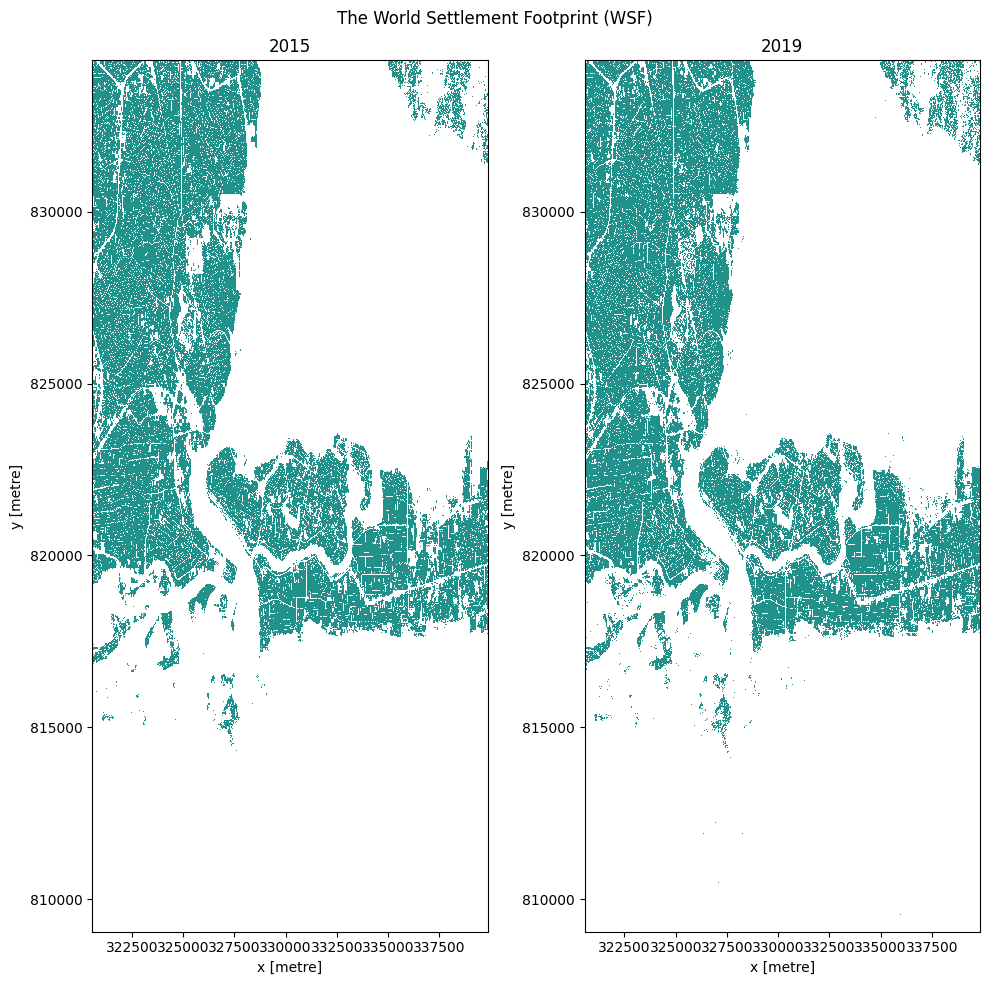

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
wsf_2015.where(wsf_2015 == 255).wsf2015.plot(ax=ax[0], add_colorbar=False)
wsf_2019.where(wsf_2019 == 255).wsf2019.plot(ax=ax[1], add_colorbar=False)

ax[0].set_title("2015")
ax[1].set_title("2019")
plt.suptitle('The World Settlement Footprint (WSF)')
plt.tight_layout();

In [8]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [9]:
wsf_2015_area = wsf_2015.wsf2015.sum(dim=['x', 'y']) * area_per_pixel
wsf_2019_area = wsf_2019.wsf2019.sum(dim=['x', 'y']) * area_per_pixel

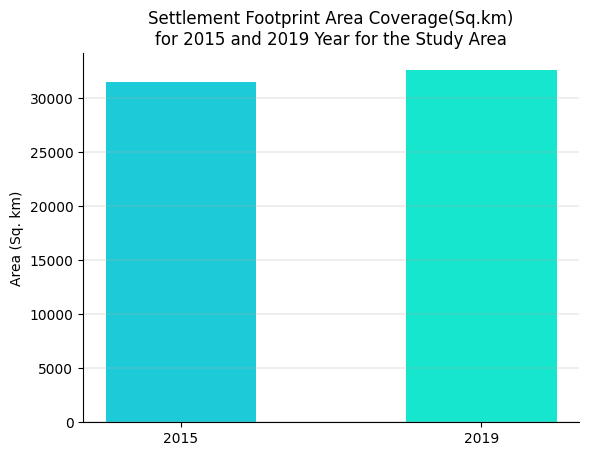

In [10]:
fig, ax = plt.subplots()
ax.bar(x = ['2015', '2019'], height = [wsf_2015_area, wsf_2019_area], 
       color=['#1ccad8','#15E6CD'], width=0.5)
 
ax.set_ylabel("Area (Sq. km)")
ax.set_title(f"Settlement Footprint Area Coverage(Sq.km)\n" 
             "for 2015 and 2019 Year for the Study Area")
ax.grid(axis='y', linewidth=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [11]:
wsf_change =  wsf_2015.wsf2015 - wsf_2019.wsf2019

In [12]:
wsf_change

<xarray.DataArray (y: 2536, x: 1930)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y            (y) float64 8.344e+05 8.344e+05 ... 8.091e+05 8.091e+05
  * x            (x) float64 3.206e+05 3.206e+05 ... 3.398e+05 3.398e+05
    spatial_ref  int32 6933

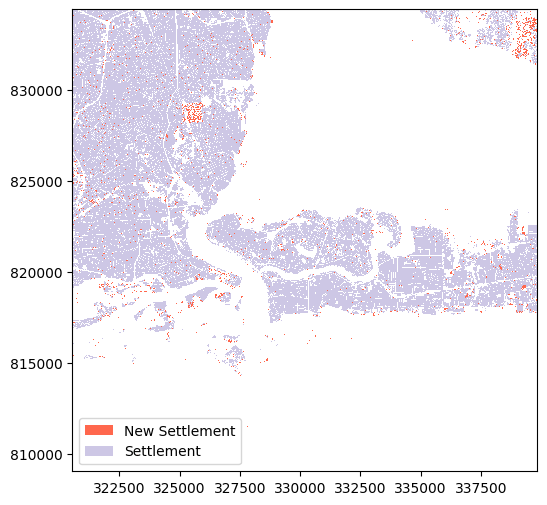

In [15]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

change = '#ff674d'
stable = '#cdc7e5'

wsf_2015.where(wsf_2015 == 255).wsf2015.plot.imshow(cmap=ListedColormap([stable]), 
                                               add_colorbar=False, add_labels=False, 
                                               figsize=(6,6))
                             
wsf_change.where(wsf_change == 1).plot.imshow(cmap=ListedColormap([change]), 
                           add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=change), Patch(facecolor=stable)],
        ['New Settlement', 'Settlement'],
         loc = 'lower left');

plt.title('');

plt.show()

In [14]:
wsf_evolution = dc.load(product='wsf_evolution',
                        measurements='wsfevolution',
                        **query).squeeze()

display(wsf_evolution)

<xarray.Dataset>
Dimensions:       (y: 2536, x: 1930)
Coordinates:
    time          datetime64[ns] 2000-07-01T23:59:59.999500
  * y             (y) float64 8.344e+05 8.344e+05 ... 8.091e+05 8.091e+05
  * x             (x) float64 3.206e+05 3.206e+05 ... 3.398e+05 3.398e+05
    spatial_ref   int32 6933
Data variables:
    wsfevolution  (y, x) int32 2010 2011 2011 2011 2010 2010 ... 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Plotting data

We can plot LULC for Madagascar and add a legend which corresponds to the classes using the DE Africa wrapper function `plot_lulc`. We can see that trees dominate the eastern areas of the island, while scrub/shrub is more prevalent on the western side. We can also identify a few cities/towns with the red 'built area' class.  You may also notice that the different datasets don't always agree.

In [ ]:
wsf_evolution = wsf_evolution.where(wsf_evolution.wsfevolution != 0).wsfevolution

In [ ]:
np.unique(wsf_evolution)

In [ ]:
(wsf_evolution == 2000).plot()

In [ ]:
(wsf_evolution.isin([1985, 1995, 2005, 2015]).plot()

### Plot the datasets

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(22,16), sharey=True)
plot_lulc(ds_io[measurements], product='IO', legend=True, ax=ax[0,0])
plot_lulc(ds_esa[measurements], product='ESA', legend=True, ax=ax[1,0])
plot_lulc(ds_cgls[measurements], product='CGLS', legend=True, ax=ax[0,1])
plot_lulc(ds_cci[measurements], product='CCI', legend=True, ax=ax[1,1])
ax[0,0].set_title('ESRI/IO Land Cover')
ax[1,0].set_title('ESA WorldCover 2020')
ax[0,1].set_title('CGLS Classification 2019')
ax[1,1].set_title('CCI Classification 2019')
plt.tight_layout();

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')